In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

import pymc3 as pm

print(f"Running on PyMC3 v{pm.__version__}")

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.5


In [19]:
import theano.tensor as tt
import arviz as az

In [15]:
from utils import preprocess_data, pca
from sklearn.cluster import DBSCAN

In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma

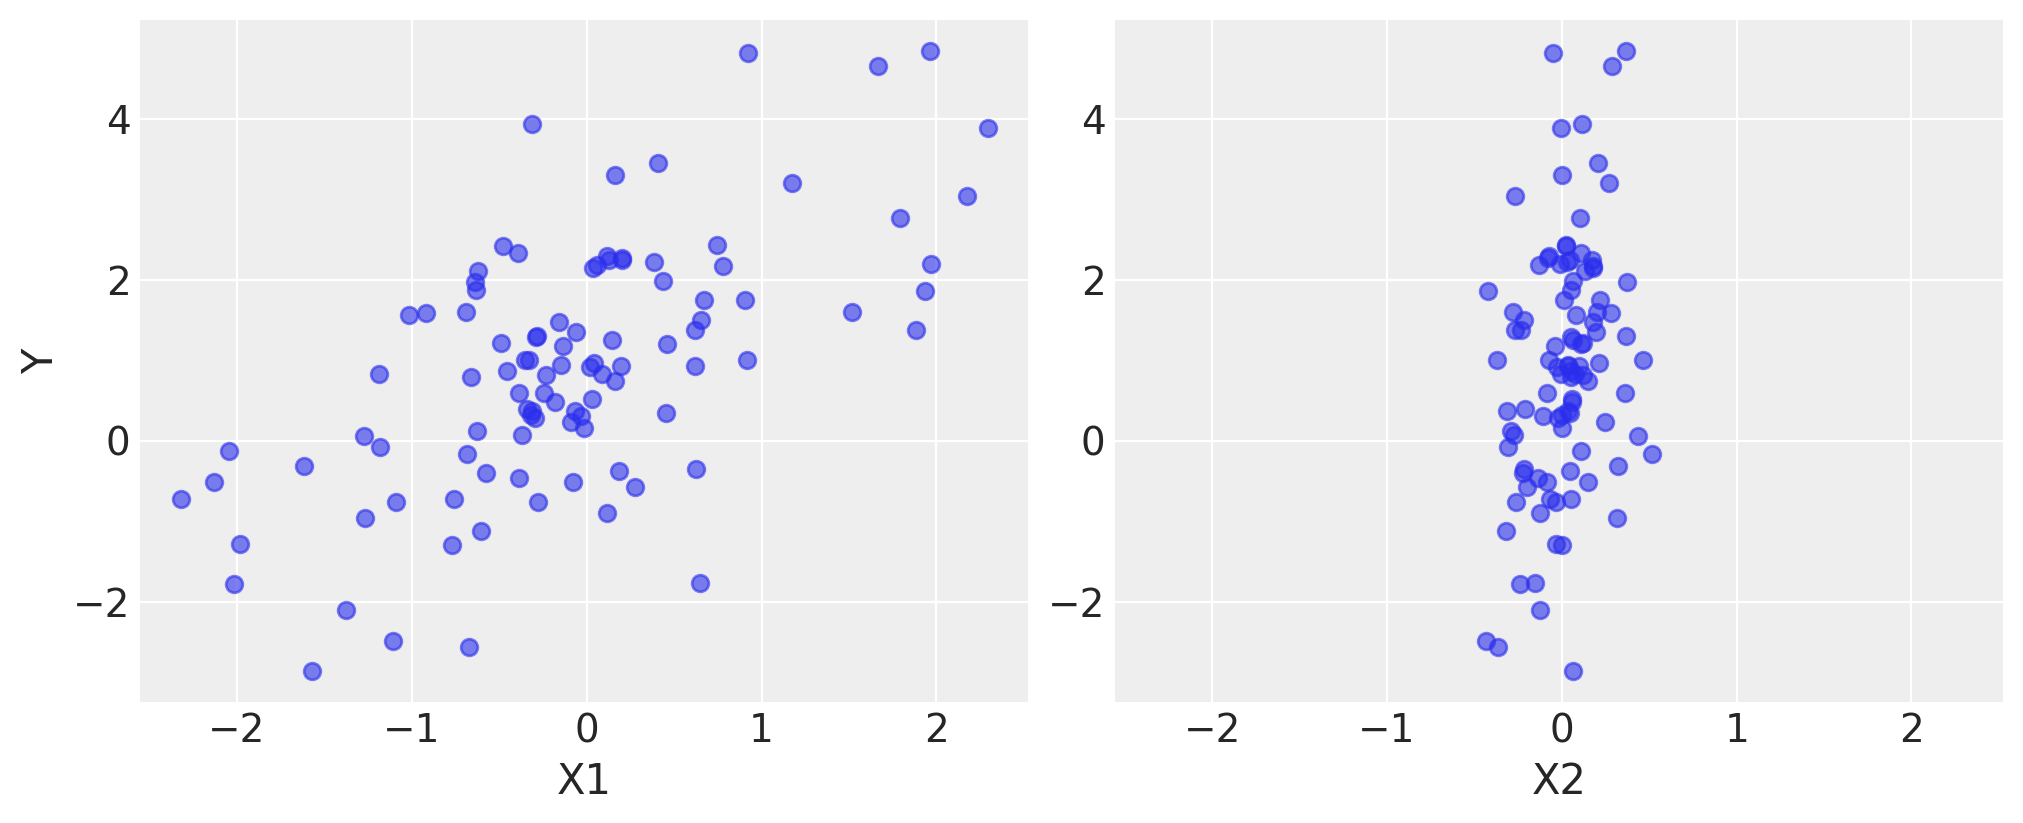

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2")

In [5]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [6]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'alpha': array(0.95724679),
 'beta': array([1.10071814, 2.9511438 ]),
 'sigma_log__': array(0.03540151),
 'sigma': array(1.0360356)}

In [7]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 25 seconds.
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\arviz\utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\arviz\utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


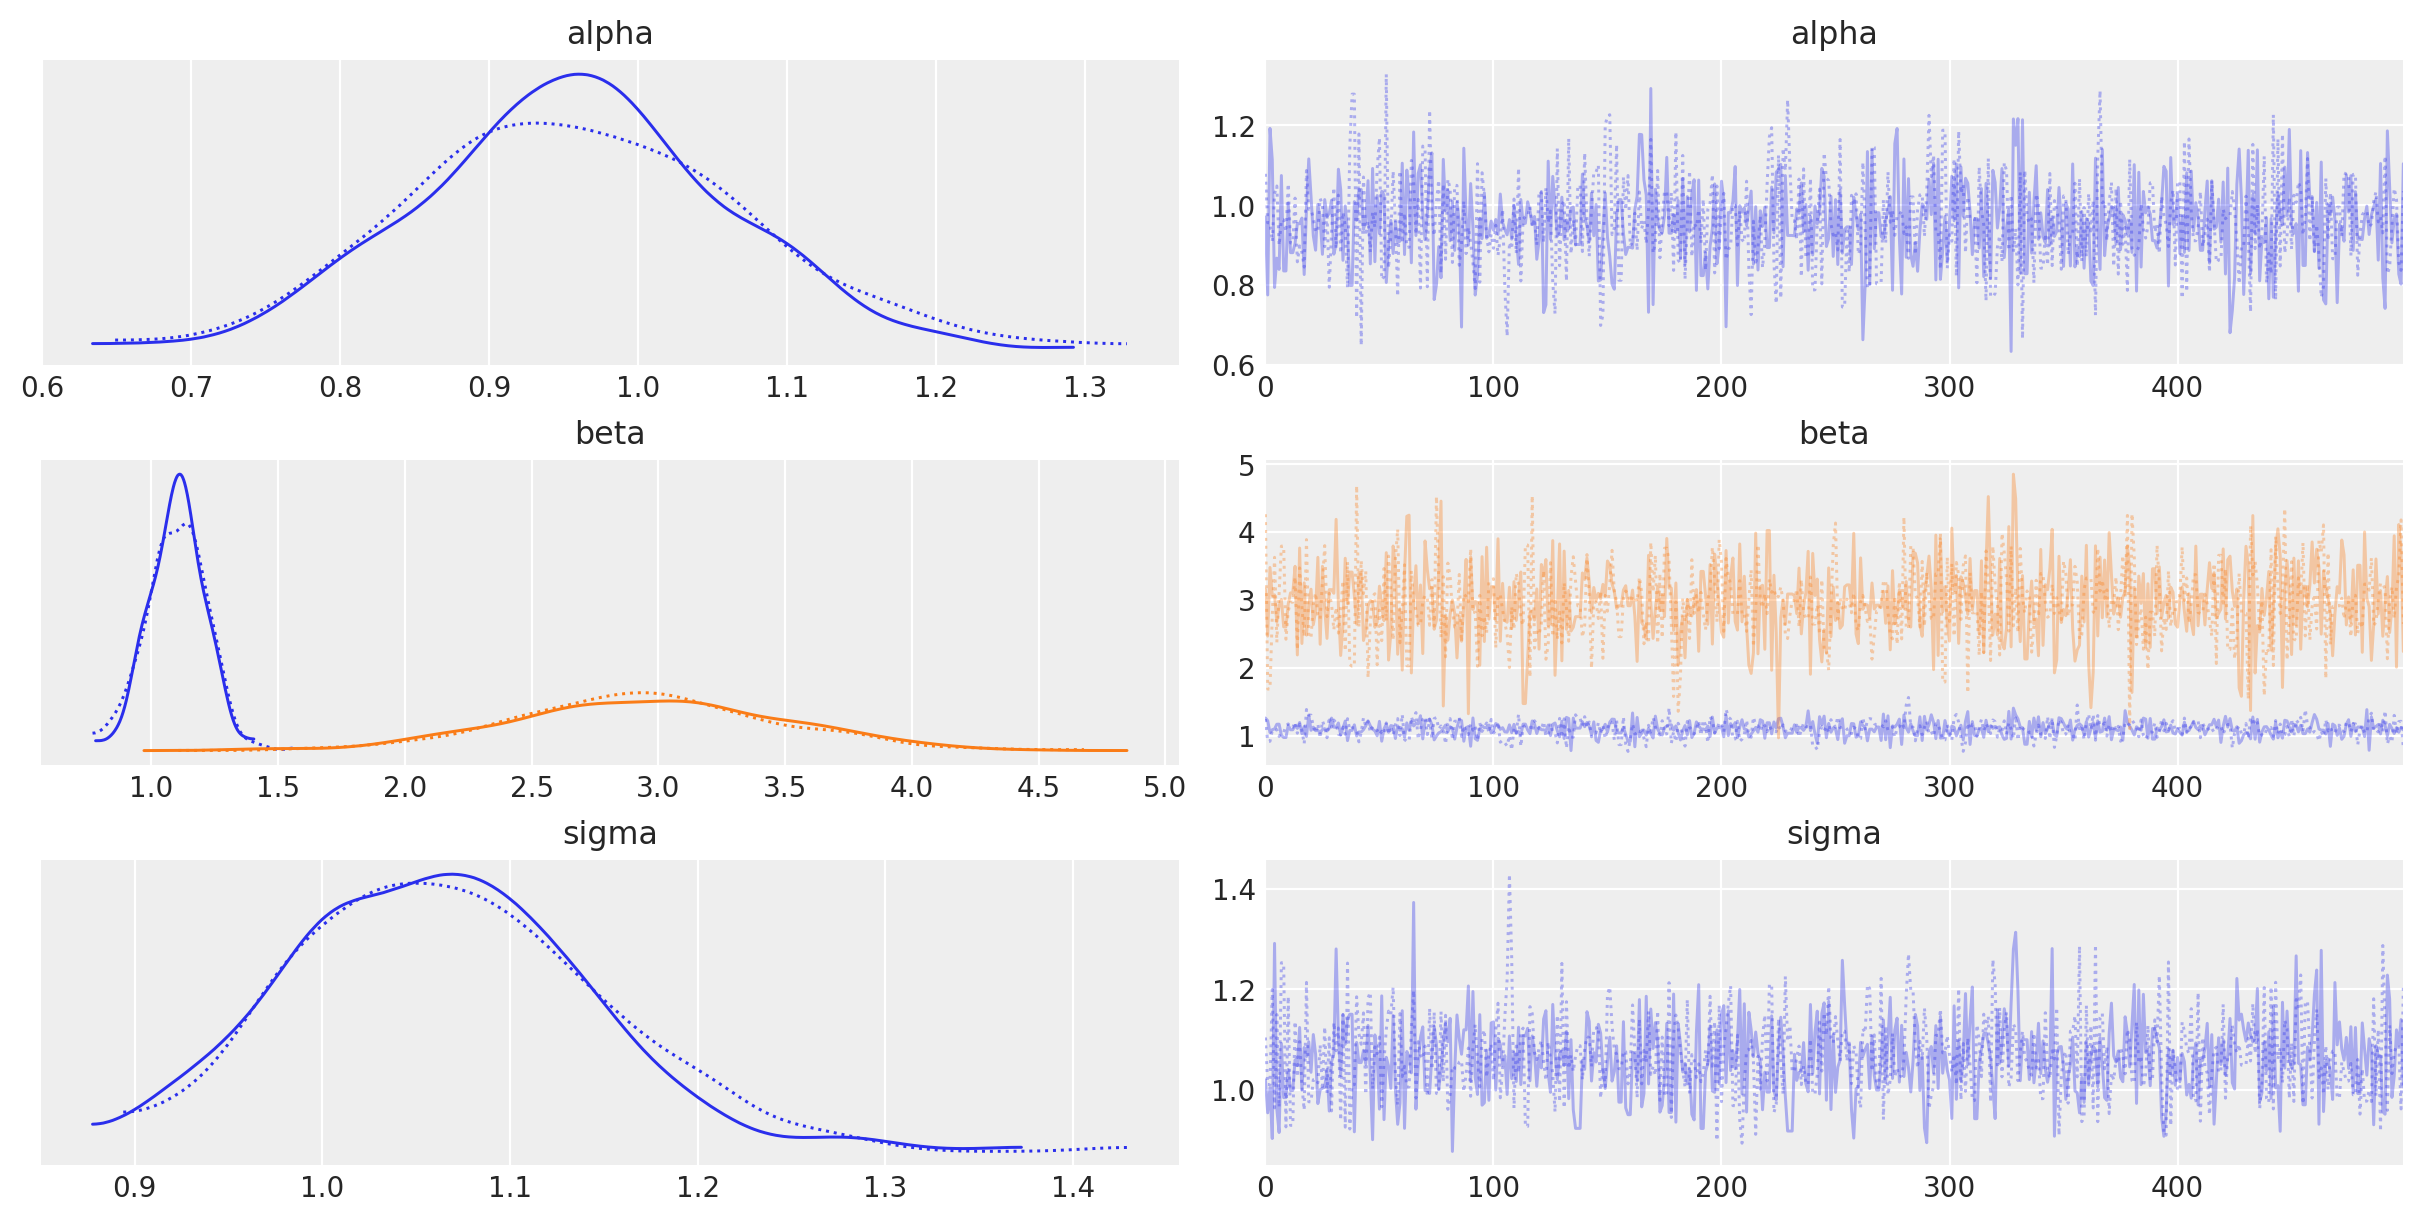

In [8]:
with basic_model:
    az.plot_trace(trace)

In [10]:
with basic_model:
    display(az.summary(trace, round_to=3))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.958,0.108,0.750,1.153,0.003,0.002,1574.886,493.689,1.003
beta[0],1.100,0.113,0.898,1.313,0.003,0.002,1201.544,614.718,1.009
beta[1],2.955,0.552,1.852,3.905,0.015,0.011,1402.640,789.489,1.001
sigma,1.065,0.079,0.922,1.207,0.003,0.002,950.231,628.675,1.002


In [18]:
path = "./gss_16.rda"

import pyreadr

data = pyreadr.read_r(path)
df = data["gss16"]

x, y_obs = preprocess_data(df=df, remove_email_null=True, use_text_categorical=False)

U, reduced_x, _, _ = pca(x, alpha=0.45)

print(reduced_x, reduced_x.shape)

[[ 0.76516265 -1.16874744 -0.15042556]
 [ 0.0738515   0.73155778  1.01875332]
 [ 1.41275401 -0.15268227 -0.10413859]
 ...
 [ 1.26932849 -0.34444335 -0.12803762]
 [ 0.61683124  0.36932971 -1.26404303]
 [ 1.47759915 -0.40272091  0.23605025]] (1648, 3)


In [22]:
ndata = x.shape[0]
nparam = reduced_x.shape[1]
clustering = DBSCAN(eps=0.50, min_samples=4).fit(reduced_x)
#clustering = AgglomerativeClustering(n_clusters=3, linkage="complete").fit(reduced_x)
clus_label = clustering.labels_
nclass = len(np.unique(clus_label))

ndata, nparam, nclass, clus_label

(1648, 3, 6, array([0, 1, 0, ..., 0, 3, 0], dtype=int64))

In [30]:
clus_label += 1

In [25]:
reduced_x = reduced_x.astype(np.float64)
clus_label = clus_label.astype(np.int64)

In [31]:
with pm.Model() as model_s:
    alpha = pm.Normal('alpha', mu=0, sd=5, shape=nclass)
    beta = pm.Normal('beta', mu=0, sd=5, shape=(nparam, nclass))
    mu = pm.Deterministic('mu', alpha + pm.math.dot(reduced_x, beta))
    theta = tt.nnet.softmax(mu)
    yl = pm.Categorical('yl', p=theta, observed=clus_label)
    traces_s = pm.sample(2000)

c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 456 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [33]:
with model_s:
    az.plot_trace(traces_s)

Error in callback <function flush_figures at 0x00000214916C6670> (for post_execute):


KeyboardInterrupt: 

: 